In [12]:
import utils
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


# Préparation des données

In [13]:
players_info_list = utils.get_dataframes_csv_file('../data/players_infos')
players_stats_list = utils.get_dataframes_csv_file('../data/players_stats')

In [14]:
# Trier les données en fonction des années 
players_info_list.sort(key=lambda df: df['Title'][0].split('-')[0][-4:])
players_stats_list.sort(key=lambda df: df['Title'][0].split('-')[0][-4:])

In [15]:
# Selectionner depuis l'année 1980 pour les statistiques en raison du manques de statistiques avant les années 80s et enlever saison en cours
players_stats_list = players_stats_list[68:-1]

players_info_list = players_info_list[:-1]

In [16]:
# Diviser les données des stats des joueurs en fonctions du type de saison 
players_stats_list_summer_league = []
players_stats_list_playoffs = []
players_stats_list_regular_season = []
players_stats_list_preseason = []

for df in players_stats_list:
    year = df['Title'].iloc[0].split(' ')[1]

    if year == '2023-2024':
        continue

    season_type = df['Title'].iloc[0].split(' ')[2]
    
    # Ajouter les données au dictionnaire approprié
    if season_type == 'Playoffs':
        players_stats_list_playoffs.append(df)
    elif season_type == 'Regular_Season':
        players_stats_list_regular_season.append(df)
    elif season_type == 'Preseason':
        players_stats_list_preseason.append(df)

In [17]:
# Combiner les DataFrames en un seul pour chaque liste
players_info = pd.concat(players_info_list)
players_stats = pd.concat(players_stats_list_regular_season)

# Conversion de la colonne 'Title' pour extraire l'année de la saison
players_info['Season'] = players_info['Title'].apply(lambda x: x.split()[1])
players_stats['Season'] = players_stats['Title'].apply(lambda x: x.split()[1])

# Suppression des colonnes 'Title' après extraction de la saison
players_info.drop(columns=['Title'], inplace=True)
players_stats.drop(columns=['Title'], inplace=True)

# Jointure des DataFrames sur le nom des joueurs et la saison
merged_data = pd.merge(players_info, players_stats, on=['Player', 'Season', 'GP'], how='inner')

In [18]:
# Calcul des statistiques par match et par minute pour les statistiques de jeu des joueurs
game_stats_cols = ['MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'ORB', 'DRB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF']

for col in game_stats_cols:
    merged_data[f'{col}_per_game'] = merged_data[col] / merged_data['GP']

for col in game_stats_cols[1:]:
    merged_data[f'{col}_per_min'] = merged_data[col] / merged_data['MIN']

# Players infos

#### Résumé statistique global pour les informations des joueurs

In [19]:
player_info_stats = merged_data[['HT', 'WT', 'GP']].describe().transpose()
player_info_stats_df = player_info_stats[['mean', '50%', 'std', 'min', 'max']]
player_info_stats_df.columns = ['Mean', 'Median', 'StdDev', 'Min', 'Max']
display(player_info_stats_df)

Mean     Median     StdDev        Min         Max
HT   2.003504   2.006600   0.092664   1.600200    2.311400
WT  98.637015  98.883137  12.498294  60.327785  161.025291
GP  53.444178  61.000000  25.339353   1.000000   85.000000

#### Résumé statistique par saison pour les informations des joueurs

In [20]:
seasonal_info_summary = merged_data.groupby('Season')[['HT', 'WT', 'GP']].describe().transpose()
print("Résumé statistique par saison pour les informations des joueurs:")
print(seasonal_info_summary)

Résumé statistique par saison pour les informations des joueurs:
Season     1980-1981   1981-1982   1982-1983   1983-1984   1984-1985  \
HT count  265.000000  298.000000  268.000000  270.000000  304.000000   
   mean     1.992414    1.994411    2.000250    2.000956    2.000166   
   std      0.089384    0.084620    0.089678    0.089457    0.088945   
   min      1.727200    1.727200    1.727200    1.727200    1.727200   
   25%      1.930400    1.930400    1.930400    1.930400    1.930400   
   50%      2.006600    2.006600    2.006600    2.006600    2.006600   
   75%      2.057400    2.057400    2.057400    2.057400    2.057400   
   max      2.184400    2.184400    2.260600    2.235200    2.260600   
WT count  265.000000  297.000000  268.000000  270.000000  304.000000   
   mean    92.529420   92.664187   93.348633   93.675224   93.869747   
   std     10.168801   10.121542   10.573203   10.677278   10.468626   
   min     68.038855   68.038855   68.038855   68.038855   72.574779   

#### Affichage des évolutions temporelles des informations des joueurs

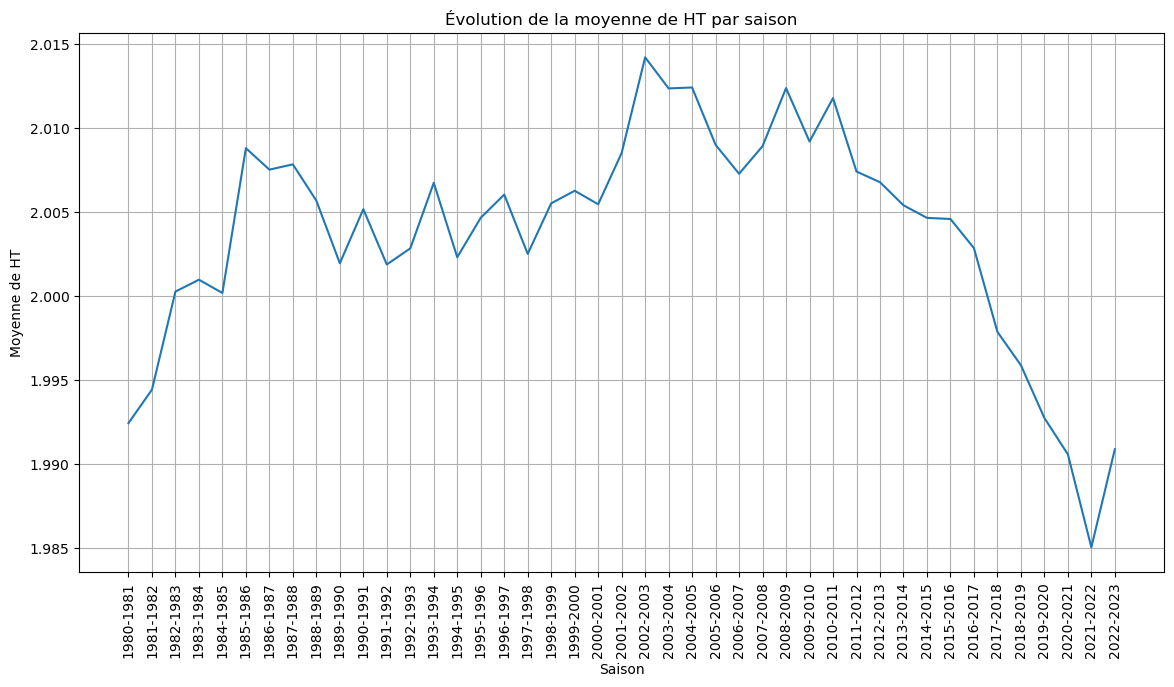

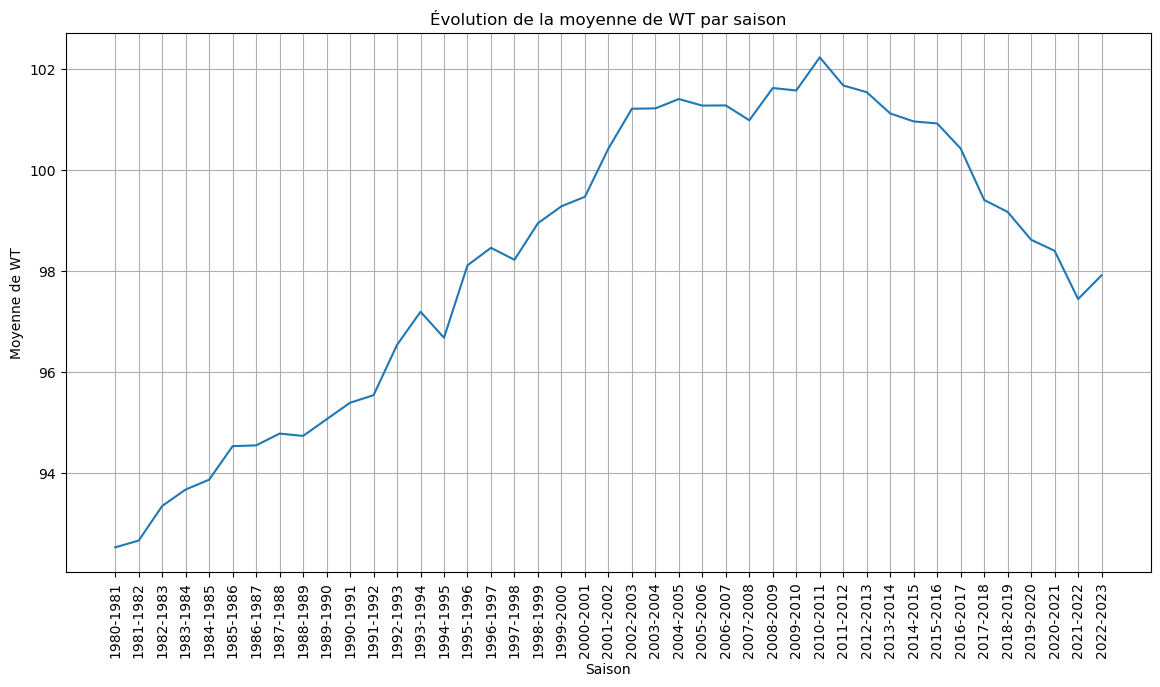

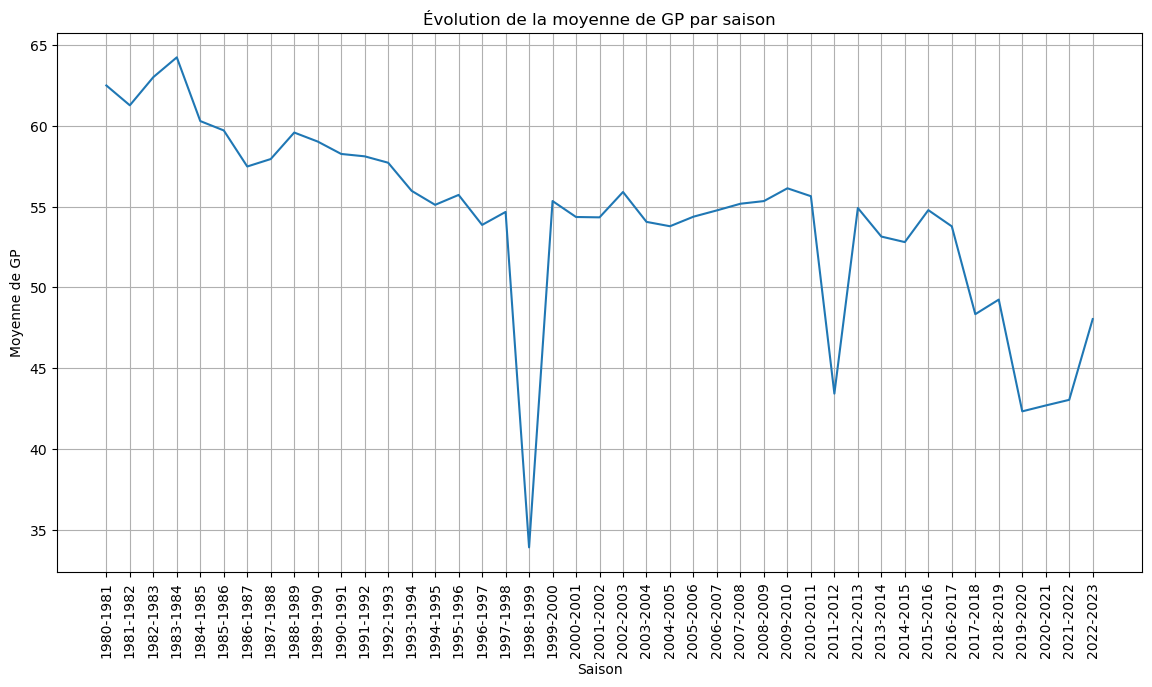

In [21]:
info_stats_to_plot = ['HT', 'WT', 'GP']

for stat in info_stats_to_plot:
    seasonal_mean_info = merged_data.groupby('Season')[stat].mean()
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=seasonal_mean_info)
    plt.title(f"Évolution de la moyenne de {stat} par saison")
    plt.xlabel("Saison")
    plt.ylabel(f"Moyenne de {stat}")
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.show()

# Conclusion par rapport aux informations des joueurs 

- La tailles des joueurs ne varie pas en fonction des années et reste aux alentours des 2 mètres
- Le poid des joueurs varie l'égerement par rapport aux années mais reste entre 93 kg et 102 kg
- Les matches par saisons varie en foncton des années :
 
    Certaines saisons ont moins de matchs joué que d'autres pour différentes raisons :
    - la saison 1999-2000 est la saison avec le moins de matches joués, cela est du à un raccourcissement de la saison : En raison du retard causé par une grève des joueurs qui a duré 191 jours.
    - La saison 2011-2012 à subit un retardement du  début de la saison
    - Les saisons 2019-2020, 2020-2021, 2021-2022 ont était impacté par la pandemie du COVID-19

    En globalité, les matchs par saisons sont en diminution au fil des années.
    
    Hypothése : il y'a plus de joueurs disponible par equipe au fil des années.

# Players statistics

#### Résumé statistique global pour les statistiques par match des joueurs

In [22]:
player_game_stats_per_game = merged_data[['MIN'] + [f'{col}_per_game' for col in game_stats_cols] + [f'{col}_per_min' for col in game_stats_cols]].describe().transpose()
player_game_stats_per_game_df = player_game_stats_per_game[['mean', '50%', 'std', 'min', 'max']]
player_game_stats_per_game_df.columns = ['Mean', 'Median', 'StdDev', 'Min', 'Max']
display(player_game_stats_per_game_df)


KeyError: "['MIN_per_min'] not in index"

#### Affichage des évolutions temporelles des statistiques par match des joueurs

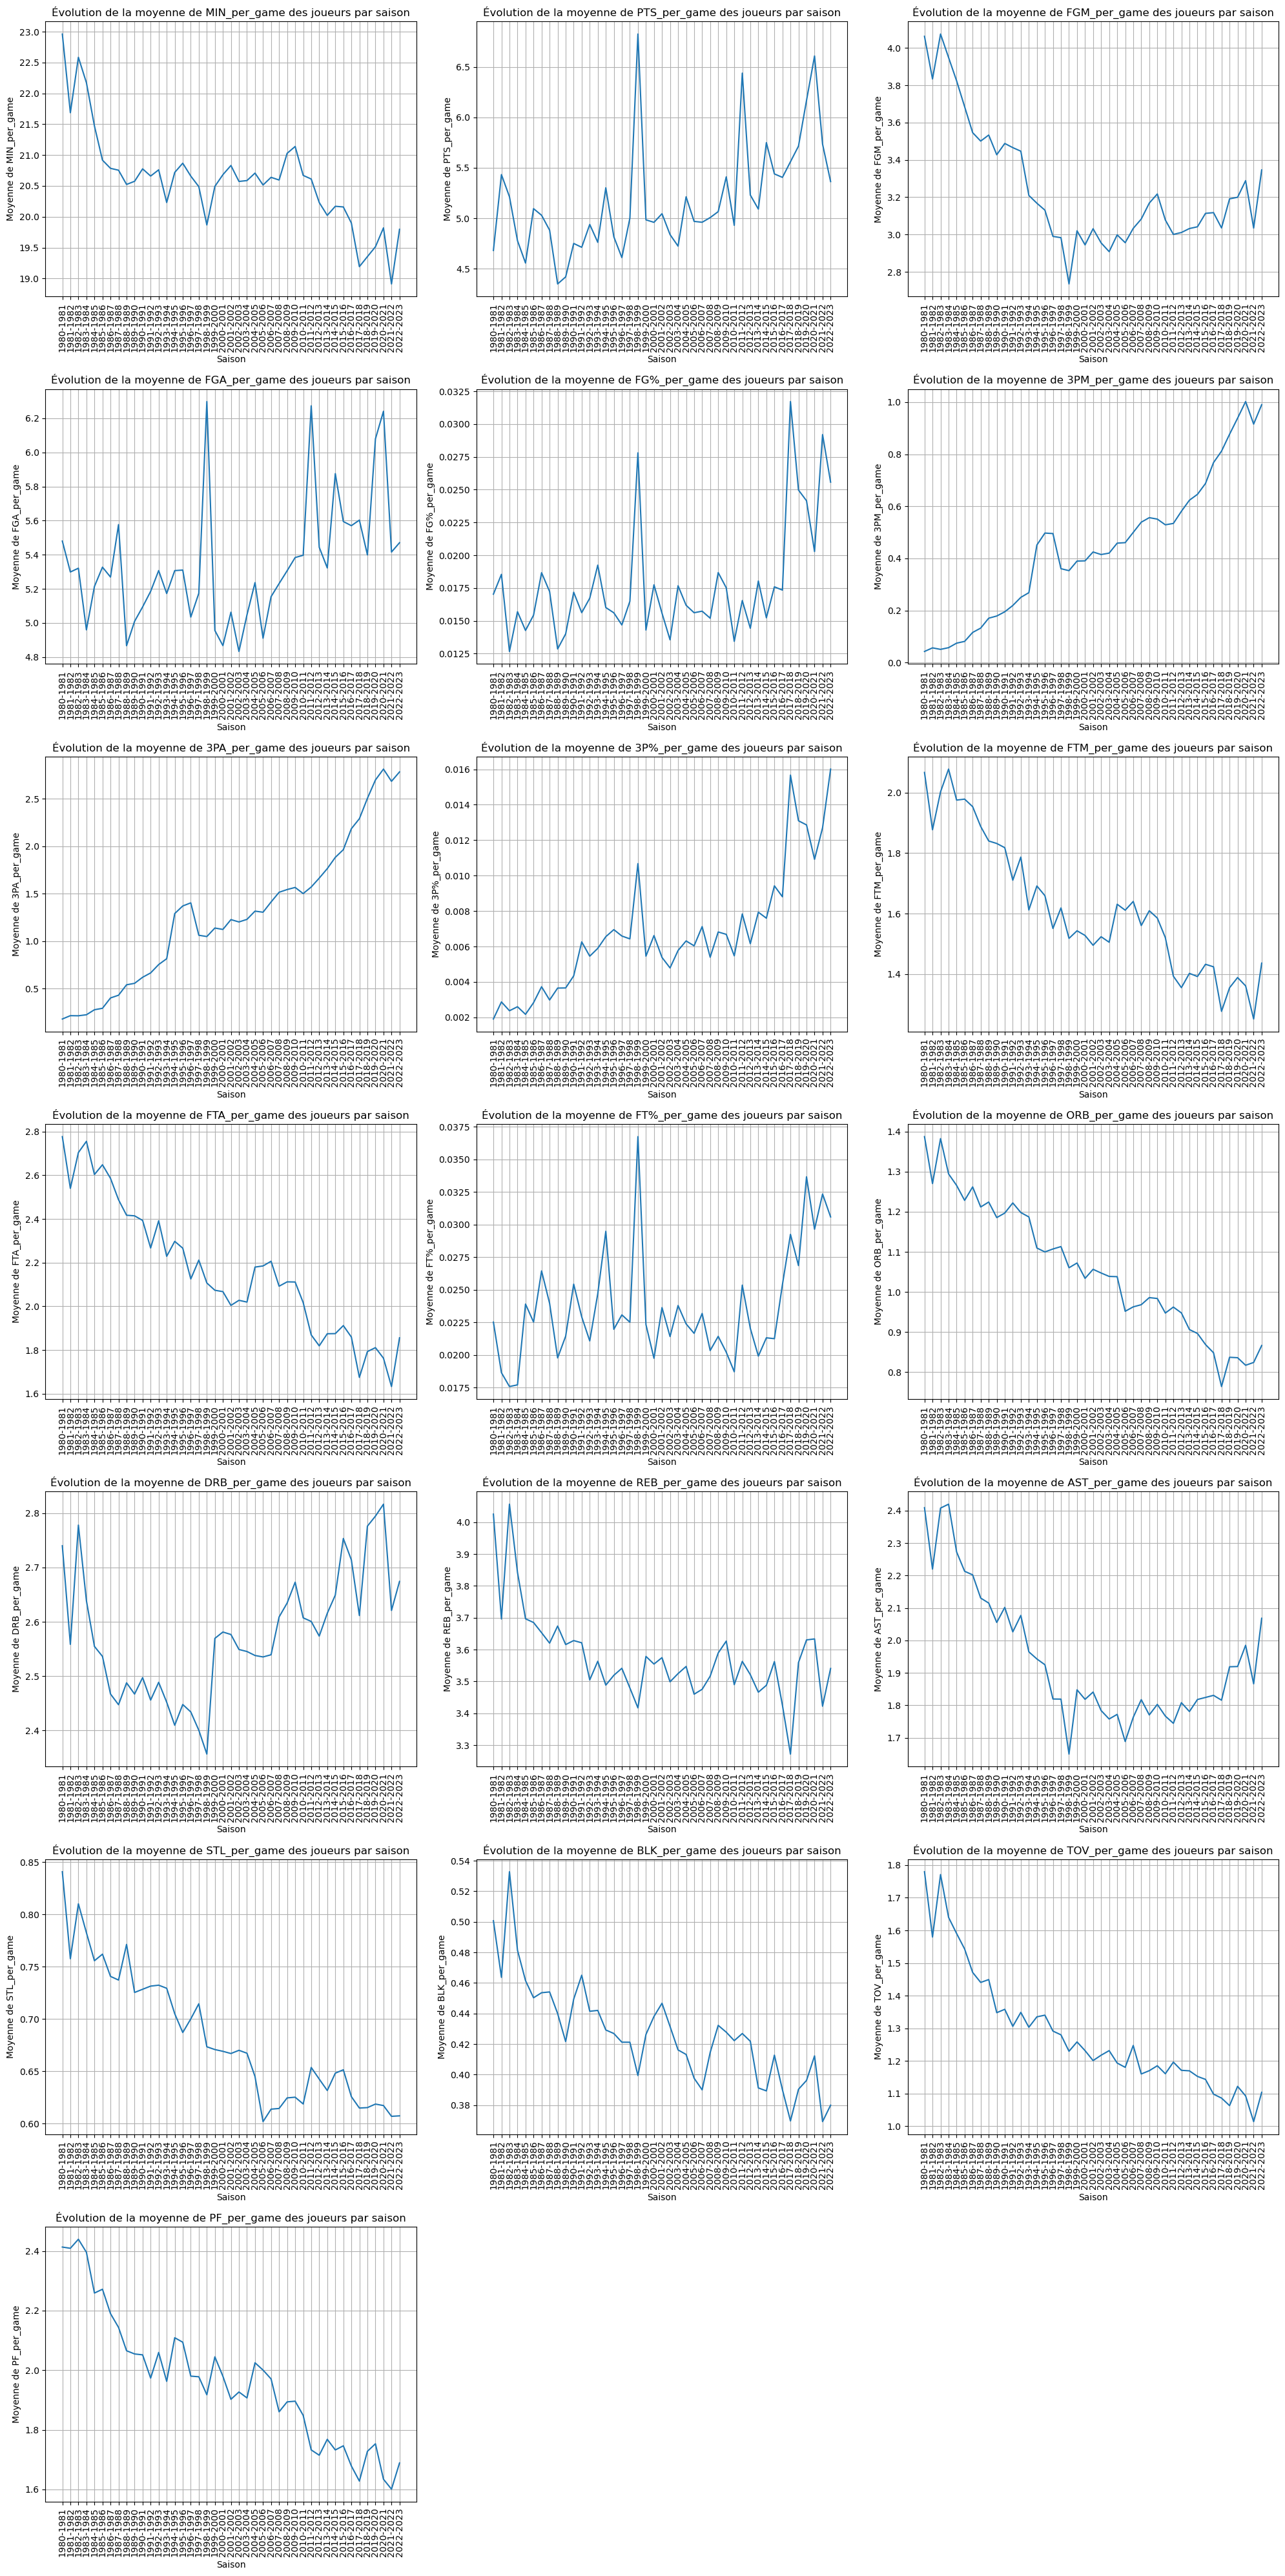

In [ ]:
game_stats_per_game_to_plot = [f'{col}_per_game' for col in game_stats_cols]

# Définir la taille de la grille
n_cols = 3
n_rows = (len(game_stats_per_game_to_plot) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 40))
axes = axes.flatten()

for i, stat in enumerate(game_stats_per_game_to_plot):
    # Calculer la moyenne par saison pour la statistique actuelle
    seasonal_mean_game_per_game = merged_data.groupby('Season')[stat].mean()
    
    # Tracer la ligne pour la statistique actuelle sur l'axe approprié
    sns.lineplot(data=seasonal_mean_game_per_game, ax=axes[i])
    
    # Définir le titre et les labels des axes
    axes[i].set_title(f"Évolution de la moyenne de {stat} des joueurs par saison")
    axes[i].set_xlabel("Saison")
    axes[i].set_ylabel(f"Moyenne de {stat}")
    
    # Rotation des étiquettes de l'axe x pour une meilleure lisibilité
    axes[i].tick_params(axis='x', rotation=90)
    
    # Activer la grille pour une meilleure lisibilité
    axes[i].grid(True)

# Supprimer les axes vides si le nombre de stats n'est pas un multiple de n_cols
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Ajuster l'espacement entre les sous-plots
plt.subplots_adjust(hspace=0.4, wspace=0.3)

plt.tight_layout()
plt.show()


#### Affichage des évolutions temporelles des statistiques par minute des joueurs

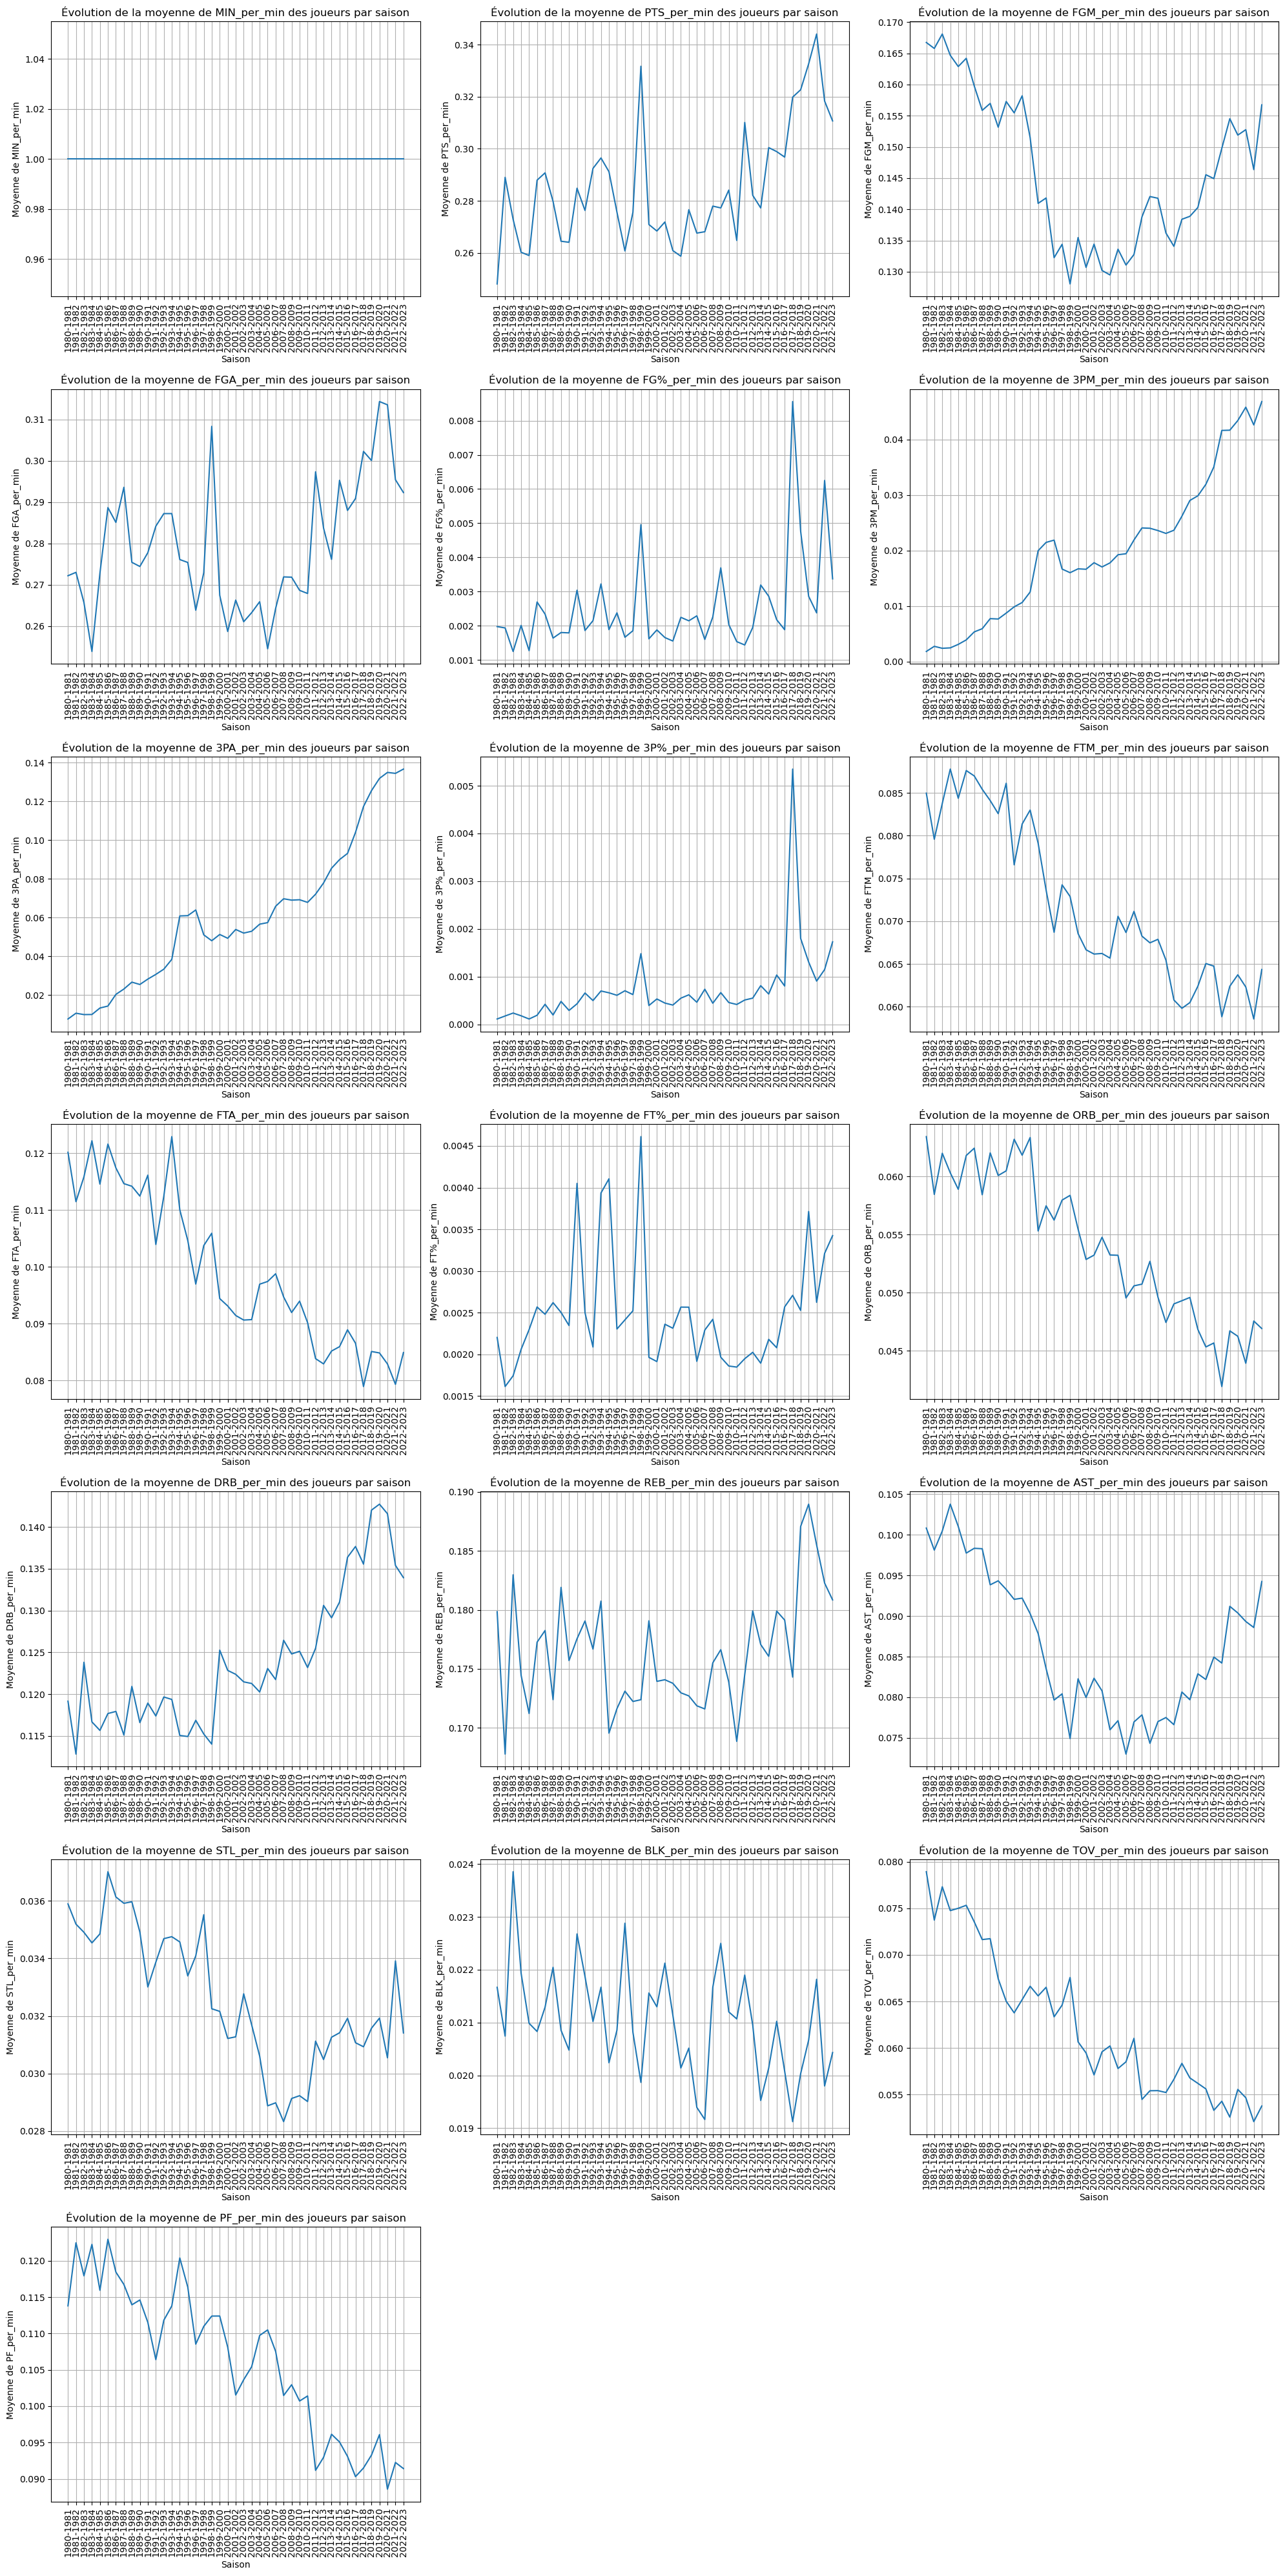

In [ ]:
game_stats_per_game_to_plot = [f'{col}_per_min' for col in game_stats_cols]

# Définir la taille de la grille
n_cols = 3
n_rows = (len(game_stats_per_game_to_plot) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 40))
axes = axes.flatten()

for i, stat in enumerate(game_stats_per_game_to_plot):
    # Calculer la moyenne par saison pour la statistique actuelle
    seasonal_mean_game_per_game = merged_data.groupby('Season')[stat].mean()
    
    # Tracer la ligne pour la statistique actuelle sur l'axe approprié
    sns.lineplot(data=seasonal_mean_game_per_game, ax=axes[i])
    
    # Définir le titre et les labels des axes
    axes[i].set_title(f"Évolution de la moyenne de {stat} des joueurs par saison")
    axes[i].set_xlabel("Saison")
    axes[i].set_ylabel(f"Moyenne de {stat}")
    
    # Rotation des étiquettes de l'axe x pour une meilleure lisibilité
    axes[i].tick_params(axis='x', rotation=90)
    
    # Activer la grille pour une meilleure lisibilité
    axes[i].grid(True)

# Supprimer les axes vides si le nombre de stats n'est pas un multiple de n_cols
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Ajuster l'espacement entre les sous-plots
plt.subplots_adjust(hspace=0.4, wspace=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# Affichage propre des résumés statistiques par saison pour les statistiques de jeu des joueurs
seasonal_game_summary_df = merged_data.groupby('Season').agg({
    'GP': ['mean', 'median', 'std', 'min', 'max'],
    'MIN': ['mean', 'median', 'std', 'min', 'max'],
    'PTS': ['mean', 'median', 'std', 'min', 'max'],
    'FGM': ['mean', 'median', 'std', 'min', 'max'],
    'FGA': ['mean', 'median', 'std', 'min', 'max'],
    'FG%': ['mean', 'median', 'std', 'min', 'max'],
    '3PM': ['mean', 'median', 'std', 'min', 'max'],
    '3PA': ['mean', 'median', 'std', 'min', 'max'],
    '3P%': ['mean', 'median', 'std', 'min', 'max'],
    'FTM': ['mean', 'median', 'std', 'min', 'max'],
    'FTA': ['mean', 'median', 'std', 'min', 'max'],
    'FT%': ['mean', 'median', 'std', 'min', 'max'],
    'ORB': ['mean', 'median', 'std', 'min', 'max'],
    'DRB': ['mean', 'median', 'std', 'min', 'max'],
    'REB': ['mean', 'median', 'std', 'min', 'max'],
    'AST': ['mean', 'median', 'std', 'min', 'max'],
    'STL': ['mean', 'median', 'std', 'min', 'max'],
    'BLK': ['mean', 'median', 'std', 'min', 'max'],
    'TOV': ['mean', 'median', 'std', 'min', 'max'],
    'PF': ['mean', 'median', 'std', 'min', 'max'],
})

print("Résumé statistique par saison pour les statistiques de jeu des joueurs:")
display(seasonal_game_summary_df)


Résumé statistique par saison pour les statistiques de jeu des joueurs:


GP                                    MIN           \
                mean median        std min max         mean   median   
Season                                                                 
1980-1981  62.503759   75.0  24.952521   1  84  1588.139098  1686.00   
1981-1982  61.275168   74.0  24.576099   1  84  1477.607383  1516.50   
1982-1983  63.018657   75.5  23.752698   3  83  1565.548507  1567.00   
1983-1984  64.244444   76.0  23.440335   1  82  1590.266667  1725.50   
1984-1985  60.299342   72.0  24.755155   1  82  1451.871711  1476.00   
1985-1986  59.720000   72.0  25.168661   1  83  1401.913846  1389.00   
1986-1987  57.486567   68.0  26.006545   1  82  1359.970448  1303.00   
1987-1988  57.948795   69.0  25.425095   1  84  1370.602410  1258.50   
1988-1989  59.589235   70.0  24.392356   1  82  1402.726346  1338.00   
1989-1990  59.031496   71.0  25.129435   1  82  1403.572178  1367.00   
1990-1991  58.263566   70.0  25.262001   1  82  1383.103359  1355.00   
1991-1992  58.116580   67.0  24.913552   1  84  1386.813472  1340.50   
1992-1993  57.720513   69.0  24.884646   2  83  1372.205128  1365.50   
1993-1994  55.980149   67.0  26.045876   1  82  1324.590571  1236.00   
1994-1995  55.113022   62.0  25.282288   1  82  1315.995086  1144.00   
1995-1996  55.727273   64.0  25.325687   1  83  1339.324242  1219.00   
1996-1997  53.870748   62.0  25.871783   1  83  1304.240590  1066.00   
1997-1998  54.674260   62.0  25.760950   1  82  1310.068337  1236.00   
1998-1999  33.909091   39.0  16.401870   1  50   796.932045   763.00   
1999-2000  55.348519   63.0  25.766854   1  85  1308.132118  1208.00   
2000-2001  54.360544   62.0  25.691335   1  83  1305.034014  1182.00   
2001-2002  54.338636   63.0  25.223942   1  83  1306.068182  1239.00   
2002-2003  55.908879   66.0  25.616220   1  83  1344.434579  1321.00   
2003-2004  54.058824   61.0  25.721889   1  85  1300.378054  1186.50   
2004-2005  53.788793   63.0  25.251106   1  84  1282.317026  1213.50   
2005-2006  54.379913   61.0  24.488639   1  82  1300.344541  1202.60   
2006-2007  54.770742   63.0  24.446831   1  82  1300.784498  1296.40   
2007-2008  55.181818   65.0  25.085768   2  82  1317.303326  1316.00   
2008-2009  55.346067   63.0  24.624326   1  82  1336.297753  1225.00   
2009-2010  56.138009   64.5  24.131376   1  82  1345.018326  1310.75   
2010-2011  55.648230   62.5  23.940478   1  83  1316.488496  1236.05   
2011-2012  43.426778   49.0  19.810049   1  66  1002.204603   939.40   
2012-2013  54.918977   61.0  24.367772   1  82  1267.535608  1187.90   
2013-2014  53.149378   61.0  25.399725   1  83  1234.861203  1136.05   
2014-2015  52.806911   61.0  24.344049   1  83  1209.765650  1192.05   
2015-2016  54.785714   62.0  24.274576   1  82  1249.692227  1228.90   
2016-2017  53.781893   62.5  24.838733   1  82  1223.076132  1197.45   
2017-2018  48.344444   55.5  27.460545   1  82  1099.731667  1038.75   
2018-2019  49.247170   56.0  26.048763   1  82  1121.610189  1068.60   
2019-2020  42.328922   48.0  22.633224   1  74   968.005104   921.90   
2020-2021  42.692593   46.0  20.706670   1  72   965.750185   925.55   
2021-2022  43.041322   48.0  25.815570   1  82   981.412066   883.30   
2022-2023  48.040816   54.0  24.650686   1  83  1103.623933   969.80   

                                      ...         TOV                        \
                   std   min     max  ...        mean median        std min   
Season                                ...                                     
1980-1981   931.645973   5.0  3417.0  ...  121.537594  125.5  77.840624   0   
1981-1982   920.289716   6.0  3398.0  ...  107.291946  104.0  73.631158   0   
1982-1983   908.363430  12.0  3093.0  ...  122.791045  118.0  79.873268   0   
1983-1984   926.119680   3.0  3082.0  ...  116.448148  115.5  76.177761   0   
1984-1985   941.769197   7.0  3182.0  ...  106.197368   98.0  76.679784   0   
1985-1986   913.854281   2.0  3258.0  ...  101.590769   91.0  75.012068  

# Conclusion et Hypothèses par rapport aux statistiques de jeu des joueurs 

On remarque d'abord que les analyses des statistiques par match et par minute sont similaires. Par conséquent, nous allons nous concentrer sur les analyses des statistiques par match, car elles sont plus significatives (dans le sens ou ça nous parle plus)

- En globalité, le nombre de minutes jouées par partie en moyenne diminue très légèrement au fil des années.
    - Hypothèse : Peut-être plus de joueurs par équipe, donc chaque joueur joue un peu moins.



- Le nombre de paniers à 3 points marqués par joueur par match augmente en moyenne au fil du temps, passant de un peu plus de 0 au début des années 80 à 1 panier à 3 points marqué par joueur par match actuellement.
Comme le nombre de paniers à 3 points marqués, le nombre de tentatives de tirs à 3 points a aussi augmenté.
- Le pourcentage de tirs à 3 points réussis a aussi augmenté.
    - Hypothèse : Les joueurs se sont améliorés au tir à 3 points.

- Le nombre de lancers francs et de tentatives de lancers francs ont diminué au fil du temps, passant d'environ 2 à environ 1,2 pour les lancers francs, et de 2,8 à 1,6 pour les tentatives.
- Le pourcentage de lancers francs réussis a quant à lui légèrement augmenté au fil du temps.
    - Hypothèse : Les joueurs sont devenus meilleurs aux lancers francs, mais il y a moins de tentatives (ce qui mène à moins de points marqués sur les lancers francs). Cela peut être dû à plusieurs facteurs comme les règles de défense plus souples, les styles de jeu plus intérieurs, l'arbitrage plus permissif et le rythme de jeu plus lent.

- Le nombre de rebonds offensifs en moyenne par match par joueur a diminué, passant de 1,4 à 0,8.
- Le nombre d'interceptions en moyenne par match par joueur a diminué, passant de 0,85 à 0,60.
- Le nombre de contres en moyenne par match par joueur a diminué, passant de 0,5 à 0,38.
- Le nombre de ballons perdus en moyenne par match par joueur a diminué, passant de 1,8 à 1.
- Le nombre de fautes personnelles en moyenne par match par joueur a diminué, passant de 2,4 à 1,6.



##### Hypothèse Gloabel : 
Ces évolutions statistiques observées au fil du temps dans la NBA reflètent probablement des changements dans les styles de jeu, les stratégies et les règles de la ligue.
L'augmentation du nombre de tirs à 3 points et de leur pourcentage de réussite suggère que le jeu est devenu plus axé sur le tir extérieur et le jeu rapide.
La diminution du nombre de lancers francs et de tentatives pourrait s'expliquer par une défense devenue plus permissive, favorisant les duels au poste bas.
La baisse des rebonds offensifs, d'interceptions et de contres indique peut-être une transition vers un jeu plus fluide et athlétique, avec moins de confrontations physiques sous le panier.
La diminution des fautes personnelles pourrait refléter une application plus stricte des règles par les arbitres, limitant le jeu rugueux.
Dans l'ensemble, ces tendances semblent indiquer une évolution vers un style de jeu plus spectaculaire et aérien, tout en étant davantage maîtrisé et contrôlé par les équipes.
Cependant, des études plus approfondies seraient nécessaires pour mieux comprendre les facteurs explicatifs de ces changements statistiques observés dans la NBA au fil des années.

# Calculant les stats par rapport au positions (rôles) des joueurs et comparant les différentes positions :

Avant de commmencer l'analyse, voici un rappel sur les différents positions au basket : 

- C (Center) : Le pivot, souvent le joueur le plus grand et le plus fort physiquement, joue près du panier pour défendre et marquer.
- PF (Power Forward) : L'ailier fort, un joueur polyvalent qui combine taille et agilité, joue à mi-distance et près du panier.
- FC (Forward-Center) : Un joueur capable de jouer à la fois en position d'ailier fort et de pivot.
- PG (Point Guard) : Le meneur de jeu, responsable de diriger l'attaque, de distribuer le ballon et de créer des opportunités de tir.
- F (Forward) : Un terme général pour désigner un joueur jouant en position d'ailier, qui peut être soit ailier fort (PF) soit ailier (SF).
- SG (Shooting Guard) : L'arrière, un joueur souvent chargé de marquer des points à longue distance et de défendre contre les arrières adverses.
- G (Guard) : Un terme général pour désigner un joueur jouant en position de meneur (PG) ou d'arrière (SG).
- SF (Small Forward) : L'ailier, un joueur polyvalent et athlétique, capable de marquer de l'extérieur et de défendre plusieurs positions.
- GF (Guard-Forward) : Un joueur capable de jouer à la fois en position d'arrière et d'ailier.
- F-C (Forward-Center) : Similaire à FC, un joueur capable de jouer à la fois en position d'ailier fort et de pivot.
- G-F (Guard-Forward) : Similaire à GF, un joueur capable de jouer à la fois en position d'arrière et d'ailier.
- C-F (Center-Forward) : Un joueur capable de jouer en position de pivot et parfois en position d'ailier fort.
- F-G (Forward-Guard) : Similaire à GF et G-F, un joueur capable de jouer en position d'ailier et d'arrière.

#### Calcul des statistiques par position

In [ ]:
# Calcul des statistiques par position
stats = ['HT'] + ['WT'] + [f'{col}_per_game' for col in game_stats_cols]
position_stats = merged_data.groupby('Pos')[stats].agg(['mean', 'var', 'std', 'min', 'max'])

# Affichage des statistiques par position
print("Statistiques par position:")
display(position_stats)


Statistiques par position:


MIN_per_game                                             PTS_per_game  \
            mean         var        std       min        max         mean   
Pos                                                                         
C      18.304679   99.582215   9.979089  0.900000  41.950617     4.773444   
C-F    17.322941   73.496033   8.572983  3.000000  34.727273     4.826850   
F      18.933132   97.661497   9.882383  0.800000  42.548101     5.114322   
F-C    16.794403   87.732946   9.366587  2.000000  40.928571     4.923093   
F-G    16.559193   56.838457   7.539128  3.555556  32.089189     5.002571   
FC     19.721280   94.972433   9.745380  0.700000  40.597561     5.034533   
G      20.363347   95.170522   9.755538  0.100000  43.700000     5.531866   
G-F    21.076680  107.778492  10.381642  3.800000  42.243902     5.005904   
GF     20.684477   90.582428   9.517480  0.900000  42.400000     5.320420   
PF     20.676319  102.402790  10.119426  0.800000  43.054795     5.150167   
PG     22.936429  104.453443  10.220247  0.500000  43.525000     5.561855   
SF     22.897836  108.849757  10.433109  0.200000  42.712500     5.281906   
SG     22.485270  103.952337  10.195702  0.600000  43.085366     5.478100   

                                               ... TOV_per_game            \
           var       std       min        max  ...         mean       var   
Pos                                            ...                          
C    16.323772  4.040269  0.000000  26.457143  ...     1.161613  0.682233   
C-F  10.476166  3.236691  0.000000  11.681818  ...     0.823398  0.279964   
F    16.143384  4.017883  0.000000  24.150000  ...     1.023054  0.495176   
F-C  14.912890  3.861721  0.013122  23.733333  ...     1.014315  0.512936   
F-G  10.812469  3.288232  0.014365  13.888889  ...     0.852725  0.280551   
FC   16.875050  4.107925  0.000000  20.116279  ...     1.154056  0.511331   
G    18.484695  4.299383  0.000000  27.448276  ...     1.356236  0.681804   
G-F  16.432279  4.053675  0.000000  18.489362  ...     1.055669  0.403211   
GF   18.660474  4.319777  0.000000  24.322581  ...     1.215646  0.559909   
PF   18.449257  4.295260  0.000000  26.000000  ...     1.206189  0.608781   
PG   22.061003  4.696914  0.000000  23.714286  ...     1.687439  0.906706   
SF   23.322456  4.829333  0.000000  30.727273  ...     1.314177  0.825282   
SG   23.613796  4.859403  0.000000  26.882353  ...     1.342857  0.743822   

                             PF_per_game                                     
          std  min       max        mean       var       std  min       max  
Pos                                                                          
C    0.825974  0.0  5.041667    2.270434  0.896156  0.946655  0.0  5.000000  
C-F  0.529116  0.0  2.395062    2.155321  0.561694  0.749462  0.0  3.380000  
F    0.703687  0.0  4.231707    1.852332  0.709235  0.842161  0.0  5.000000  
F-C  0.716196  0.0  3.523810    2.166272  0.797337  0.892937  0.0  4.590164  
F-G  0.529671  0.0  2.456790    1.763173  0.501690  0.708301  0.2  2.931034  
FC   0.715074  0.0  3.815385    2.234862  0.798139  0.893386  0.0  4.875000  
G    0.825714  0.0  5.407407    1.646590  0.525223  0.724722  0.0  6.000000  
G-F  0.634989  0.0  2.866667    1.873901  0.619645  0.787175  0.0  3.800000  
GF   0.748271  0.0  4.064516    1.817722  0.614463  0.783877  0.0  6.000000  
PF   0.780244  0.0  4.735294    2.174377  0.791652  0.889748  0.0  5.000000  
PG   0.952211  0.0  4.816667    1.720082  0.528185  0.726763  0.0  4.111111  
SF   0.908450  0.0  4.492308    1.887921  0.661733  0.813470  0.0  4.121951  
SG   0.862451  0.0  5.728395    1.746131  0.565833  0.752219  0.0  4.000000  

[13 rows x 95 columns]

#### Visualisation de la comparaison des statistiques entre les postes

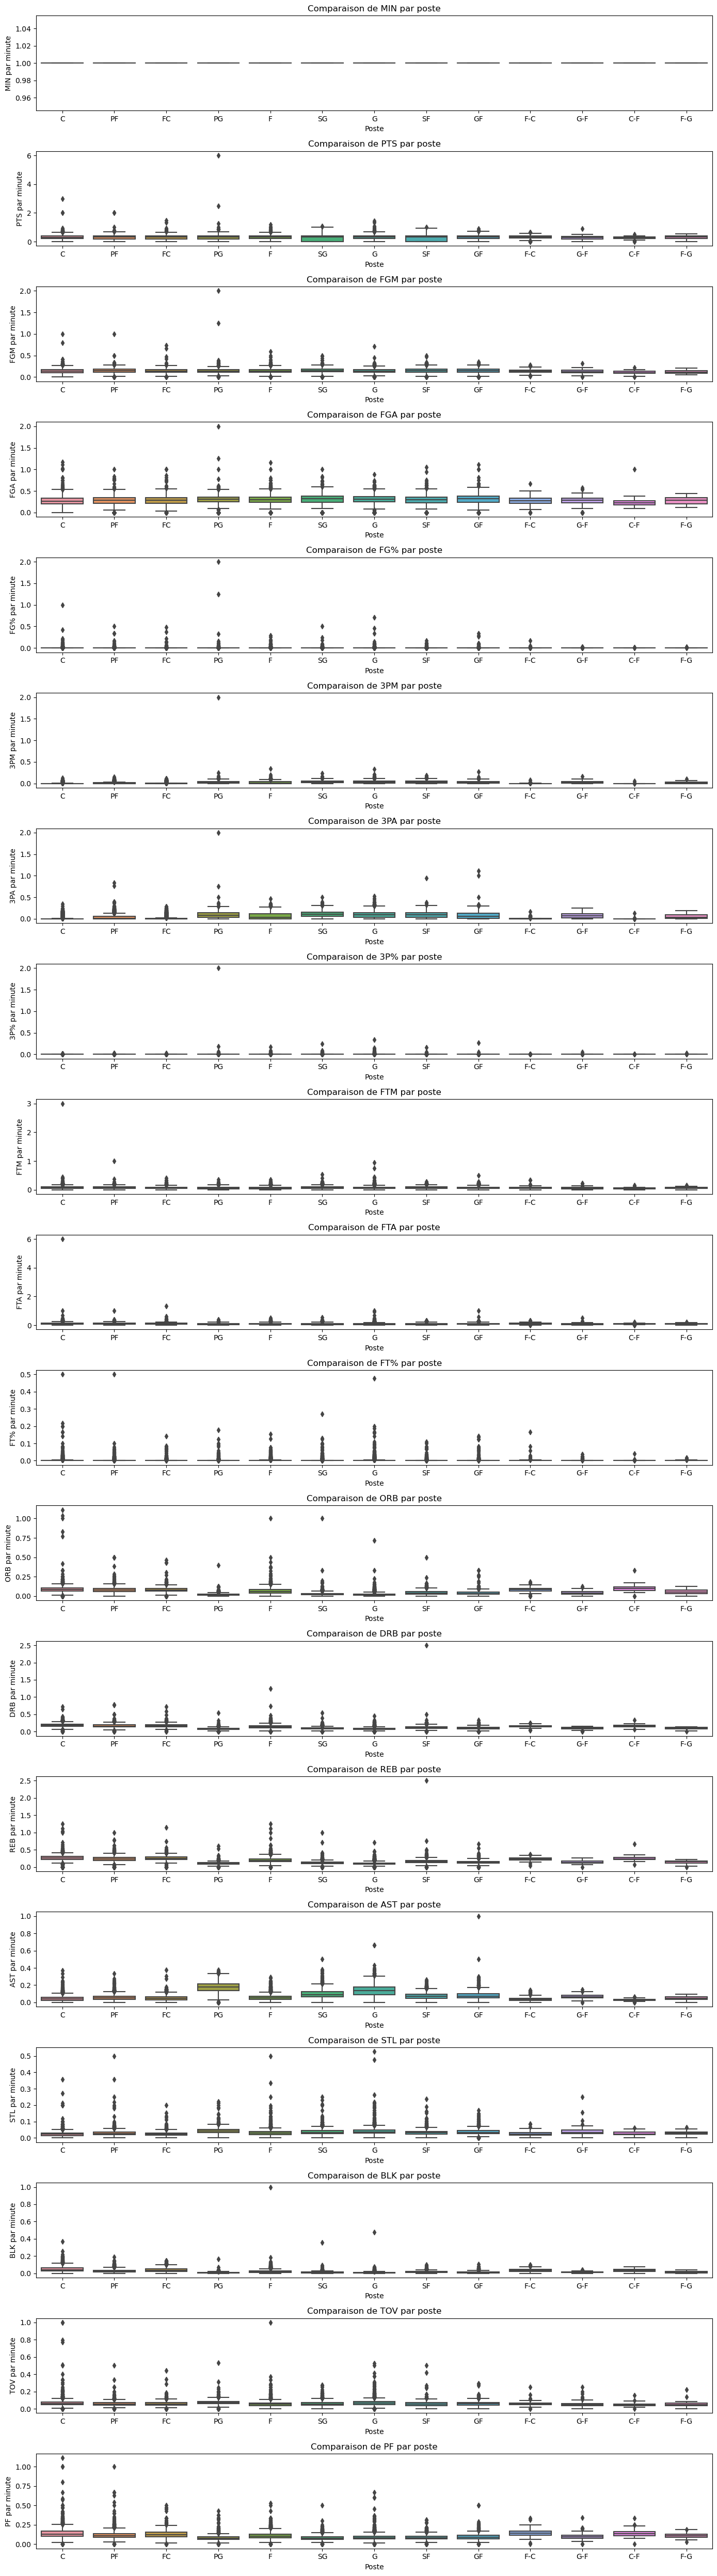

In [ ]:
# Comparaison des moyennes des statistiques par poste
fig, axes = plt.subplots(len(game_stats_cols), 1, figsize=(14, 50))

for i, col in enumerate(game_stats_cols):
    sns.boxplot(data=merged_data, x='Pos', y=f'{col}_per_min', ax=axes[i])
    axes[i].set_title(f'Comparaison de {col} par poste')
    axes[i].set_xlabel('Poste')
    axes[i].set_ylabel(f'{col}')

plt.tight_layout()
plt.show()


#### Comparaison de l'évolution des statistiques par poste

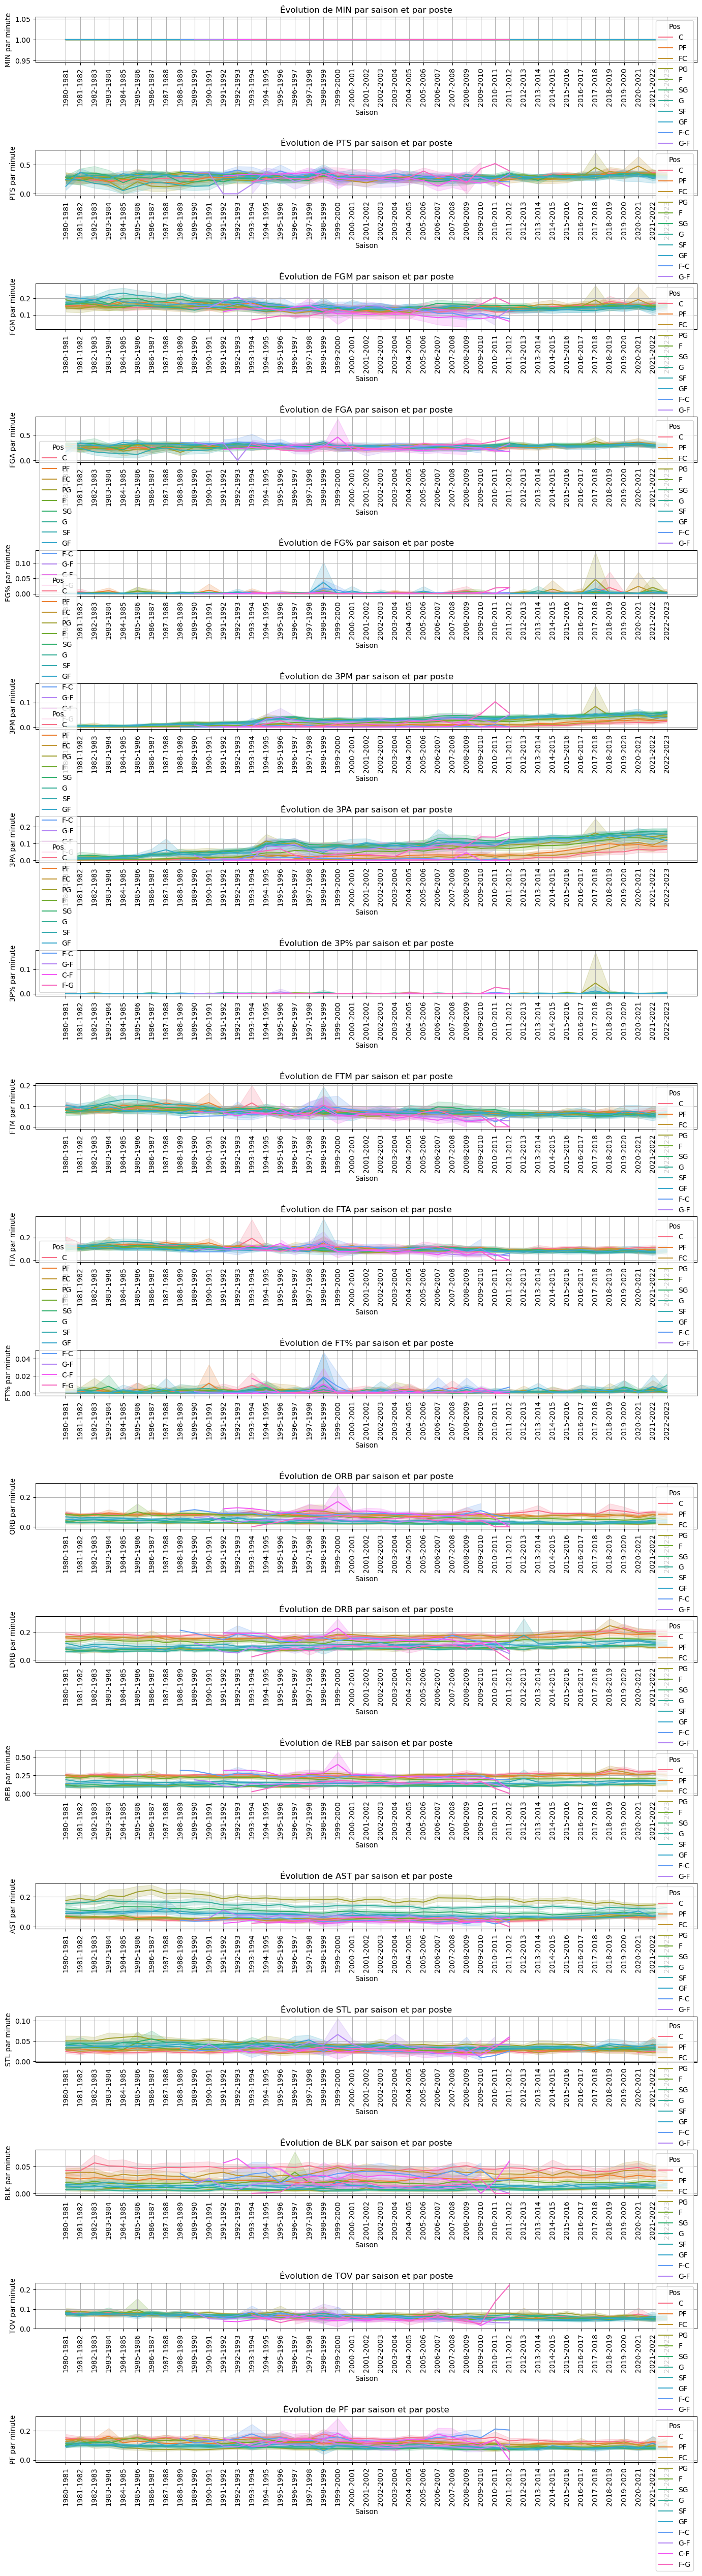

In [ ]:
# Comparaison de l'évolution des statistiques par poste
fig, axes = plt.subplots(len(game_stats_cols), 1, figsize=(14, 50))

for i, col in enumerate(game_stats_cols):
    sns.lineplot(data=merged_data, x='Season', y=f'{col}_per_min', hue='Pos', ax=axes[i])
    axes[i].set_title(f'Évolution de {col} par saison et par poste')
    axes[i].set_xlabel('Saison')
    axes[i].set_ylabel(f'{col} par minute')
    axes[i].tick_params(axis='x', rotation=90)
    axes[i].grid(True)

plt.tight_layout()
plt.show()


# Analyse des clusters 

## Calculer le nombre de clusters optimal 

In [ ]:
# Sélection des colonnes de statistiques par match pour le clustering
stats_cols = stats

# Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(merged_data[stats_cols])

# Réduction de dimensionnalité avec PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

NameError: name 'stats' is not defined

#### Méthode du coude

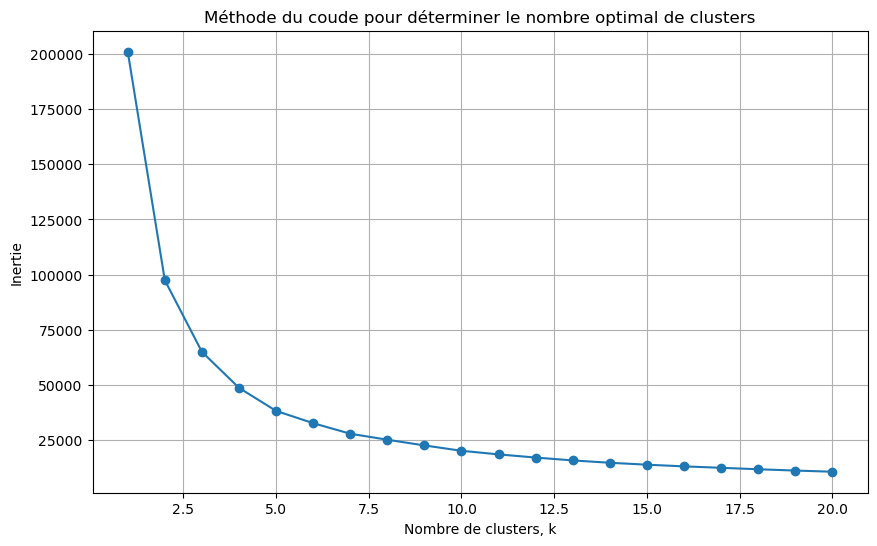

In [ ]:
# Méthode du coude pour déterminer le nombre optimal de clusters
inertia = []
k_range = range(1, 21)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# Plot de la méthode du coude
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Nombre de clusters, k')
plt.ylabel('Inertie')
plt.title('Méthode du coude pour déterminer le nombre optimal de clusters')
plt.grid(True)
plt.show()


#### Indice de silhouette

c:\Users\Kadem\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Kadem\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Kadem\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Kadem\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

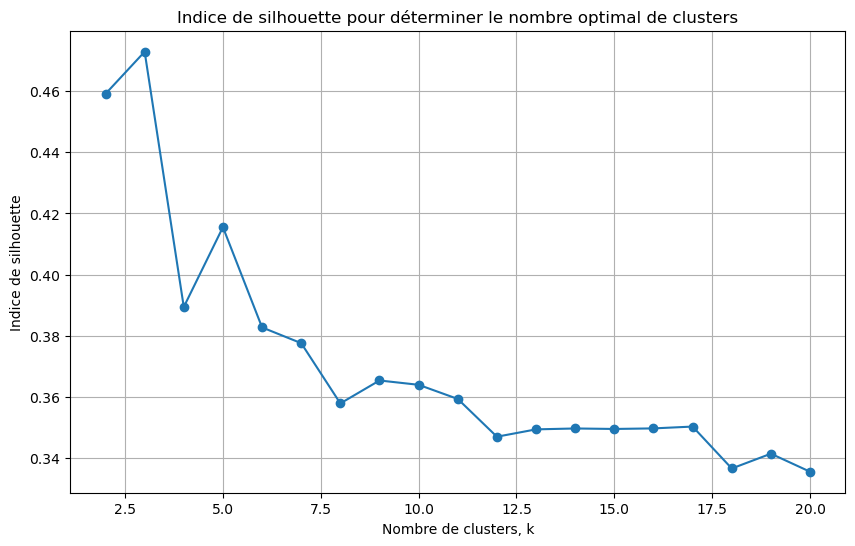

In [ ]:
# Indice de silhouette pour déterminer le nombre optimal de clusters
silhouette_scores = []
k_range = range(2, 21)  # Commencer à 2 pour éviter l'erreur
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    score = silhouette_score(X_pca, kmeans.labels_)
    silhouette_scores.append(score)

# Plot de l'indice de silhouette
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Nombre de clusters, k')
plt.ylabel('Indice de silhouette')
plt.title('Indice de silhouette pour déterminer le nombre optimal de clusters')
plt.grid(True)
plt.show()


#### interprétation des méthodes et choix du nombre de clusters

- Méthode du coude : Il faut chercher le point où l'inertie cesse de diminuer de manière significative : dans notre cas approximativement 5


- Indice de silhouette : Il faut chercher le nombre de clusters qui maximise l'indice de silhouette. Un score plus élevé indique des clusters bien séparés et compacts : dans notre cas 2 ou 3 semble être l'idéal, 5 semble être correct aussi

On choisit donc le nombre de clusters = 5

In [ ]:
n_clusters = 5

In [ ]:
# Clustering avec K-means
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Ajout des clusters aux données
merged_data['Cluster'] = clusters


c:\Users\Kadem\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### Analyse de la relation entre les clusters et la position des joueurs

#### Distribution des positions au sein de chaque cluster

Distribution des positions au sein de chaque cluster:
Pos         C  C-F     F  F-C  F-G   FC     G  G-F   GF    PF   PG   SF   SG
Cluster                                                                     
0        1109   21   903   46    9  575  1207   51  473  1008  699  810  854
1        1544   48  1570  120   49  706  2039  106  723  1193  714  817  986
Proportions des positions au sein de chaque cluster:
Pos             C       C-F         F       F-C       F-G       FC         G  \
Cluster                                                                        
0        0.142820  0.002704  0.116291  0.005924  0.001159  0.07405  0.155441   
1        0.145455  0.004522  0.147904  0.011305  0.004616  0.06651  0.192087   

Pos           G-F        GF        PF        PG        SF        SG  
Cluster                                                              
0        0.006568  0.060914  0.129813  0.090019  0.104314  0.109981  
1        0.009986  0.068111  0.112388  0.067263  0.076

<Figure size 1400x700 with 0 Axes>

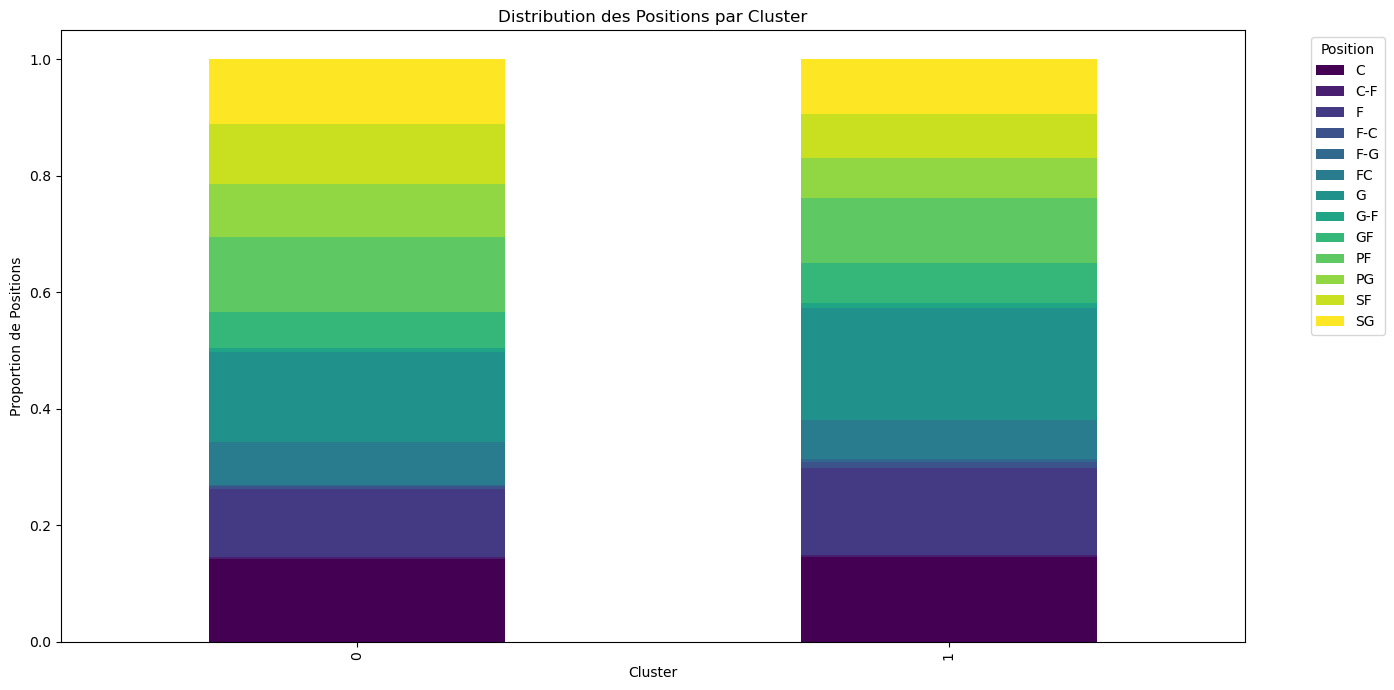

In [ ]:
# Distribution des positions au sein de chaque cluster
position_cluster_dist = merged_data.groupby(['Cluster', 'Pos']).size().unstack(fill_value=0)
print("Distribution des positions au sein de chaque cluster:")
print(position_cluster_dist)

# Normalisation pour obtenir les proportions
position_cluster_dist_norm = position_cluster_dist.div(position_cluster_dist.sum(axis=1), axis=0)
print("Proportions des positions au sein de chaque cluster:")
print(position_cluster_dist_norm)

# Visualisation de la distribution des positions pour chaque cluster
plt.figure(figsize=(14, 7))
position_cluster_dist_norm.plot(kind='bar', stacked=True, colormap='viridis', figsize=(14, 7))
plt.title('Distribution des Positions par Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion de Positions')
plt.legend(title='Position', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


#### Visualisation des clusters avec PCA

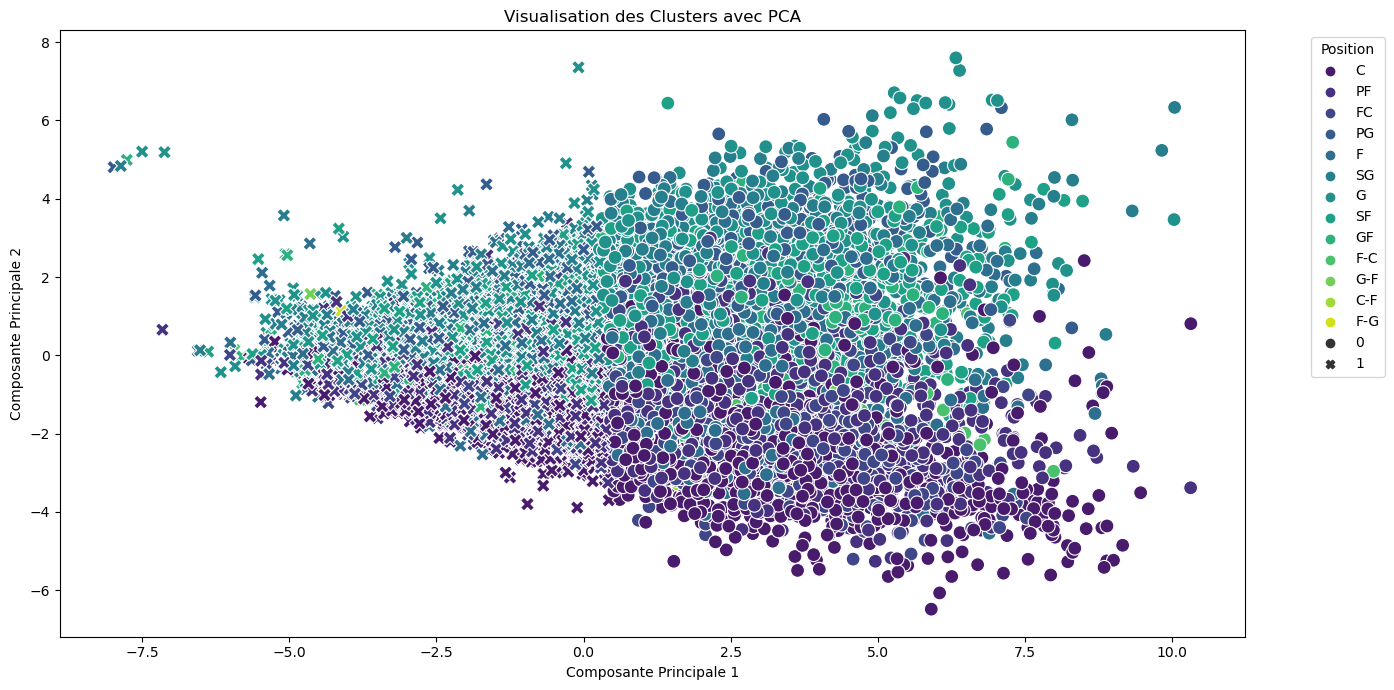

In [ ]:
plt.figure(figsize=(14, 7))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=merged_data['Pos'], palette='viridis', style=clusters, s=100)
plt.title('Visualisation des Clusters avec PCA')
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.legend(title='Position', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


#### Réduction de dimensionnalité avec t-SNE pour visualisation

In [ ]:
# Réduction de dimensionnalité avec t-SNE pour visualisation
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Visualisation des clusters avec t-SNE
plt.figure(figsize=(14, 7))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=merged_data['Pos'], palette='viridis', style=clusters, s=100)
plt.title('Visualisation des Clusters avec t-SNE')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(title='Position', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


#### Visualisation des clusters avec t-SNE dans une grille

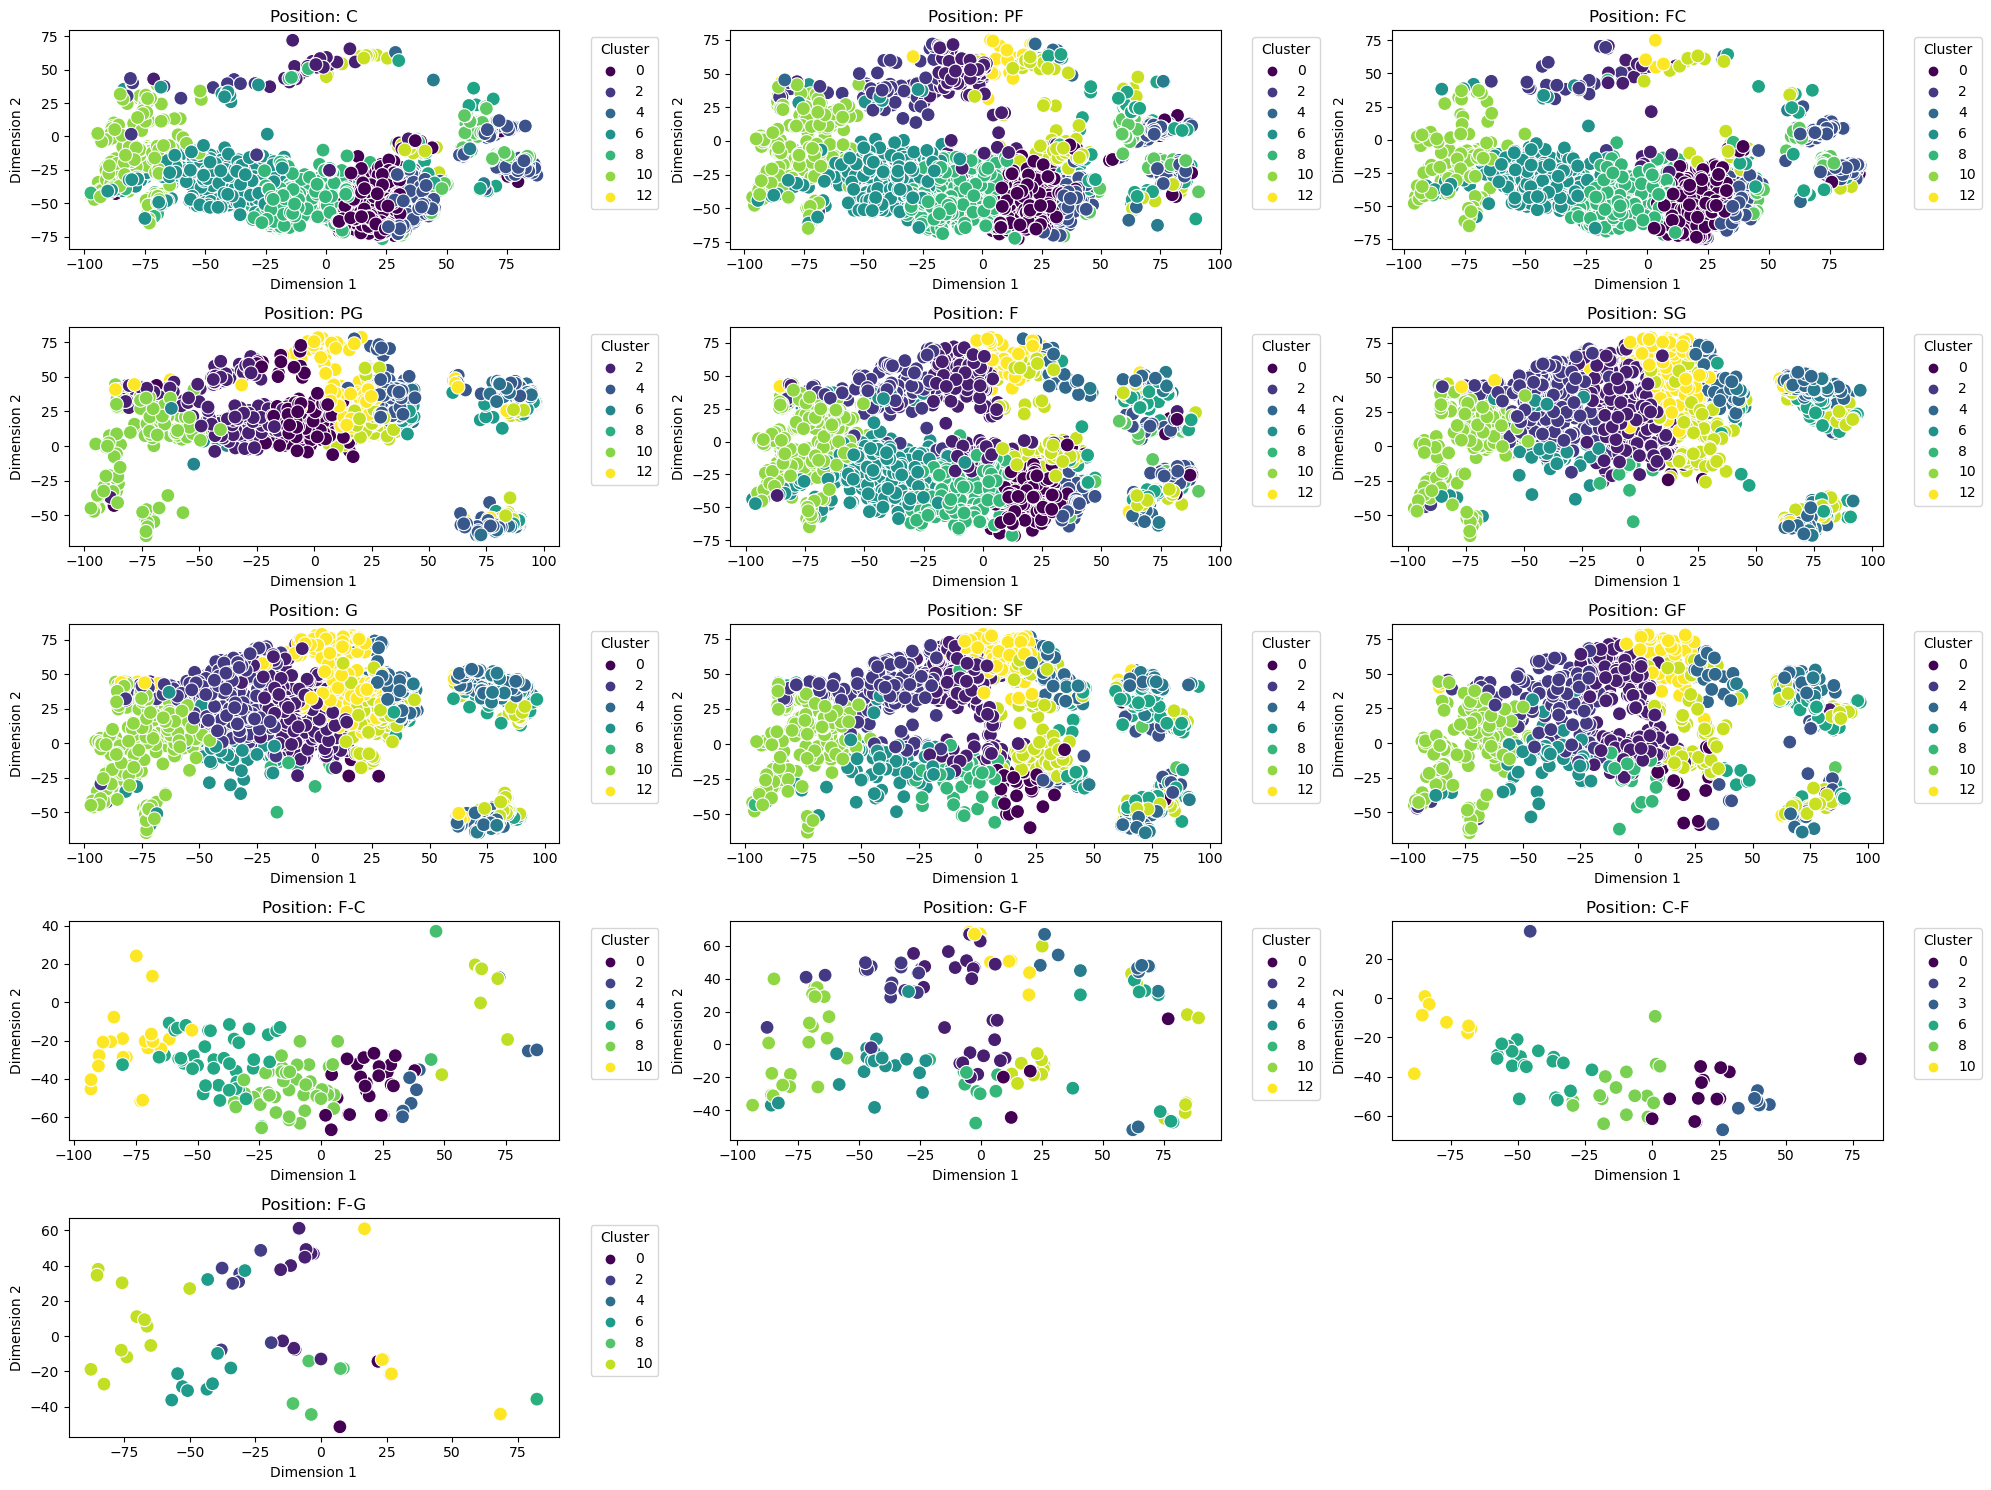

In [ ]:
# Obtenir la liste des positions uniques
positions = merged_data['Pos'].unique()

# Réduction de dimensionnalité avec t-SNE pour visualisation
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
merged_data['TSNE1'] = X_tsne[:, 0]
merged_data['TSNE2'] = X_tsne[:, 1]

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))
axes = axes.flatten()

# Visualiser chaque position dans un sous-plot différent avec t-SNE
for i, pos in enumerate(positions):
    pos_data = merged_data[merged_data['Pos'] == pos]
    sns.scatterplot(x='TSNE1', y='TSNE2', hue='Cluster', palette='viridis', data=pos_data, ax=axes[i], s=100)
    axes[i].set_title(f'Position: {pos}')
    axes[i].set_xlabel('Dimension 1')
    axes[i].set_ylabel('Dimension 2')
    axes[i].legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

# Supprimer les axes vides si le nombre de positions n'est pas un multiple de n_cols
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

